In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file using pandas
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Data inspection
print("First 5 rows of the dataset:")
print(df.head())

# Handle missing values
df = df.dropna().reset_index(drop=True)

# Encode target variable
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])  # 'bot' -> 0, 'human' -> 1

# Convert boolean columns
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode categorical features
df['lang_encoded'] = le.fit_transform(df['lang'])

# Feature selection
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'description', 'id',
    'profile_background_image_url', 'profile_image_url',
    'screen_name', 'location', 'account_type', 'lang'
])

# Define features and target
X = df_model.drop('account_type_encoded', axis=1)
y = df_model['account_type_encoded']

# Addressing class imbalance in the training data
# Separate majority and minority classes
df_majority = df_model[df_model['account_type_encoded'] == 1]  # Human
df_minority = df_model[df_model['account_type_encoded'] == 0]  # Bot

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,            # sample without replacement
                                   n_samples=len(df_minority),  # match minority class size
                                   random_state=42)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target for balanced dataset
X_balanced = df_balanced.drop('account_type_encoded', axis=1)
y_balanced = df_balanced['account_type_encoded']

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split with balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Initialize logistic regression model with cross-validation for regularization parameter
best_score = 0
best_C = None

# Test different values of C using cross-validation
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    # Using StratifiedKFold to maintain class balance in folds
    skf = StratifiedKFold(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    print(f"Mean CV Accuracy for C={C}: {mean_cv_score:.4f}")
    
    # Save the best C value based on mean cross-validation score
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_C = C

print(f"\nBest C found: {best_C} with CV Accuracy: {best_score:.4f}")

# Train the model with the best C
model = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bot', 'Human']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

First 5 rows of the dataset:
   Unnamed: 0           created_at  default_profile  default_profile_image  \
0           0  2016-10-15 21:32:11            False                  False   
1           1  2016-11-09 05:01:30            False                  False   
2           2  2017-06-17 05:34:27            False                  False   
3           3  2016-07-21 13:32:25             True                  False   
4           4  2012-01-15 16:32:35            False                  False   

                                         description  favourites_count  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...                 4   
1  Photographing the American West since 1980. I ...               536   
2  Scruffy looking nerf herder and @twitch broadc...              3307   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...              8433   
4               Loan coach at @mancity & Aspiring DJ                88   

   followers_count  friends_count  geo_enabled           

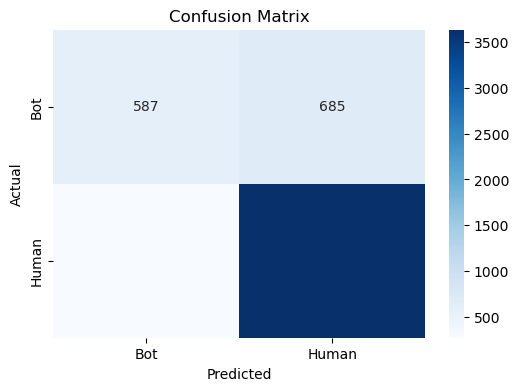

In [5]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
cm

array([[ 587,  685],
       [ 268, 3638]])


Feature Importances:
                   Feature  Importance
7                 verified    0.999428
2         favourites_count    0.973732
5              geo_enabled    0.587330
6           statuses_count    0.388981
0          default_profile    0.337781
8   average_tweets_per_day    0.312083
9         account_age_days    0.211561
4            friends_count    0.192979
10            lang_encoded    0.107165
3          followers_count    0.027835
1    default_profile_image    0.004237


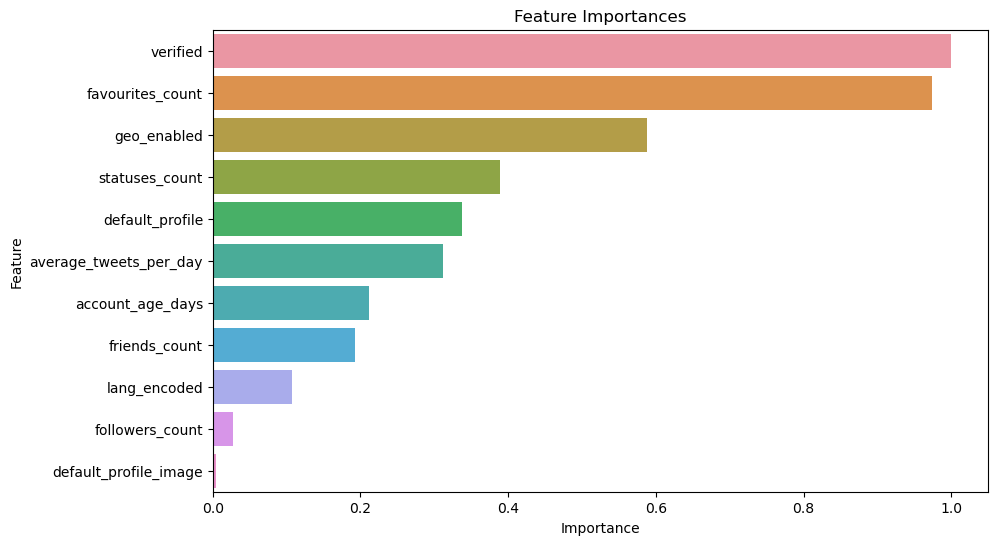

In [7]:

# Feature importance
importances = np.abs(model.coef_[0])
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 'Importance': importances
}).sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

In [8]:
# Hyperparameter tuning
c_values = [0.01, 0.1, 1, 10, 100]
for c in c_values:
    model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"C={c}: Accuracy={accuracy:.2f}")

C=0.01: Accuracy=0.81
C=0.1: Accuracy=0.82
C=1: Accuracy=0.82
C=10: Accuracy=0.82
C=100: Accuracy=0.82


In [9]:
# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]
misclassified_samples = X_test[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]

# Examine misclassified examples
sample_indices = np.random.choice(misclassified_indices, size=5, replace=False)
for idx in sample_indices:
    actual_label = 'Bot' if y_test.iloc[idx] == 0 else 'Human'
    predicted_label = 'Bot' if y_pred[idx] == 0 else 'Human'
    print(f"Index: {idx}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Features: {X_test[idx]}")
    print("-" * 50)

Index: 3732
Actual Label: Human
Predicted Label: Bot
Features: [ 1.60910345 -0.04031063 -0.39620008 -0.17661695 -0.10143171 -1.08549158
 -0.35099084 -0.61084398 -0.31219985  0.22108494 -1.09209336]
--------------------------------------------------
Index: 2611
Actual Label: Bot
Predicted Label: Human
Features: [ 1.60910345 -0.04031063 -0.32181438 -0.17652797 -0.09787916  0.9212416
 -0.32362946 -0.61084398 -0.28668166 -0.21840294 -0.83915493]
--------------------------------------------------
Index: 5024
Actual Label: Bot
Predicted Label: Human
Features: [-0.62146408 -0.04031063 -0.39795345 -0.17525707 -0.1029838  -1.08549158
 -0.15900586 -0.61084398 -0.02333101 -1.63070318 -0.33327807]
--------------------------------------------------
Index: 1918
Actual Label: Human
Predicted Label: Bot
Features: [-0.62146408 -0.04031063 -0.34755714 -0.17658831 -0.09989687 -1.08549158
 -0.34095963 -0.61084398 -0.27750111 -2.78168631 -0.33327807]
--------------------------------------------------
Index